# S3

We will use a large public datasets that is hosted in S3: the [NYC Taxi dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/). We will use Python's `boto3` library to run AWS Athena and S3 Select resources.

In [1]:
# Import necessary libraries
import boto3
import time
import pandas as pd

First, let's initialize our S3 resource via Boto3.

In [2]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

Then we can identify data that fits particular criteria within an S3 bucket by cycling through all the objects within the bucket. Here, we identify files that record Yellow Cab data from 2019:

In [11]:
bucket = 'nyc-tlc'
bucket_resource = s3_resource.Bucket(bucket)
[obj.key for obj in bucket_resource.objects.all() if '2019' in obj.key and 'yellow' in obj.key]
# note both CSVs and Parquet files -- for now will work with CSV, but will see a lot of Parquet later in the course

['csv_backup/yellow_tripdata_2019-01.csv',
 'csv_backup/yellow_tripdata_2019-02.csv',
 'csv_backup/yellow_tripdata_2019-03.csv',
 'csv_backup/yellow_tripdata_2019-04.csv',
 'csv_backup/yellow_tripdata_2019-05.csv',
 'csv_backup/yellow_tripdata_2019-06.csv',
 'csv_backup/yellow_tripdata_2019-07.csv',
 'csv_backup/yellow_tripdata_2019-08.csv',
 'csv_backup/yellow_tripdata_2019-09.csv',
 'csv_backup/yellow_tripdata_2019-10.csv',
 'csv_backup/yellow_tripdata_2019-11.csv',
 'csv_backup/yellow_tripdata_2019-12.csv',
 'trip data/yellow_tripdata_2019-01.parquet',
 'trip data/yellow_tripdata_2019-02.parquet',
 'trip data/yellow_tripdata_2019-03.parquet',
 'trip data/yellow_tripdata_2019-04.parquet',
 'trip data/yellow_tripdata_2019-05.parquet',
 'trip data/yellow_tripdata_2019-06.parquet',
 'trip data/yellow_tripdata_2019-07.parquet',
 'trip data/yellow_tripdata_2019-08.parquet',
 'trip data/yellow_tripdata_2019-09.parquet',
 'trip data/yellow_tripdata_2019-10.parquet',
 'trip data/yellow_tripd

So, we seem to have a number of files that fit this criteria. We could assess the general content of a file by previewing the file.

In [5]:
def s3_csv_preview(bucket, key, rows=10):
    '''
    Preview CSV in S3 Bucket as Pandas DataFrame
    '''
    data_source = {
            'Bucket': bucket,
            'Key': key
    }

    url = s3.generate_presigned_url(ClientMethod='get_object',
                                    Params=data_source)

    data = pd.read_csv(url, nrows=rows)
    return data

t0 = time.time()
df = s3_csv_preview(bucket='nyc-tlc',
                    key='csv_backup/yellow_tripdata_2019-12.csv',
                    rows=10)
print(time.time() - t0, 'seconds')

df.head()

38.13610863685608 seconds


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1,4.2,1,N,142,116,2,14.5,3.0,0.5,0.0,0,0.3,18.3,2.5
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0,0.3,3.8,0.0
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0,0.3,3.8,0.0
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,1,N,138,25,1,28.5,0.5,0.5,10.0,0,0.3,39.8,0.0
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2,1.6,1,N,161,237,2,9.0,3.0,0.5,0.0,0,0.3,12.8,2.5


We can also use S3 Select (via Boto3) to gather only a subset of the data that meets the criteria we're interested in. S3 Select is a serverless approach, which effectively spins up compute cores for us, searches for particular criteria in parallel, and then returns the results of the search to our local machine.

Let's select 100 passenger_count and trip_distance datapoints, where the number of passengers in the cab was greater than 3. 

In [6]:
import io

def s3_select(Bucket, Key, Expression):
    s3_select_results = s3.select_object_content(
        Bucket=Bucket,
        Key=Key,
        Expression=Expression,
        ExpressionType='SQL',
        InputSerialization={'CSV': {"FileHeaderInfo": "Use"}},
        OutputSerialization={'JSON': {}})
    
    df = pd.DataFrame()
    for event in s3_select_results['Payload']:
        if 'Records' in event:
            df = pd.read_json(io.StringIO(event['Records']['Payload'].decode('utf-8')),
                              lines=True)
    return df

t0 = time.time()
df = s3_select(Bucket='nyc-tlc', 
               Key='csv_backup/yellow_tripdata_2019-12.csv',
               Expression='''
                          SELECT passenger_count, trip_distance
                          FROM s3object s
                          WHERE s.passenger_count > '3'
                          LIMIT 100
                          '''
)
print(time.time() - t0, 'seconds')
df

0.279116153717041 seconds


,passenger_count,trip_distance
0,5,19.98
1,4,0.80
2,4,2.60
3,4,0.90
4,5,16.53
...,...,...
95,5,0.63
96,5,6.27
97,6,0.92
98,5,1.21


Then, with this subset of data, we can use our standard Pandas tools to calculate summary statistics and make plots.

In [7]:
(df.groupby('passenger_count')
   .describe()
)

trip_distance                                                 \
                        count      mean       std   min    25%    50%    75%   
passenger_count                                                                
4                        39.0  4.234103  4.863248  0.00  0.850  2.180  6.180   
5                        40.0  3.459500  3.934379  0.16  1.515  2.085  4.255   
6                        21.0  1.957143  1.187287  0.74  1.070  1.640  2.570   

                        
                   max  
passenger_count         
4                21.00  
5                19.98  
6                 5.37

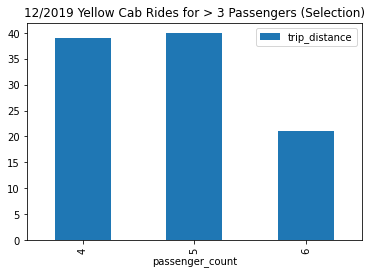

In [8]:
(df.groupby('passenger_count').count()
                              .plot
                              .bar(legend=True,
                                   title='12/2019 Yellow Cab Rides for > 3 Passengers (Selection)')
);